In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/Users/armankhan/code/nasa_hacks/csv/GlobalWeatherRepository.csv')

df.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [4]:
print("Dataset Info:")
print(df.info())
print("\n" + "="*70)
print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False).head(20))
print("\n" + "="*70)
print(f"\nUnique Countries: {df['country'].nunique()}")
print(f"Unique Locations: {df['location_name'].nunique()}")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98604 entries, 0 to 98603
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       98604 non-null  object 
 1   location_name                 98604 non-null  object 
 2   latitude                      98604 non-null  float64
 3   longitude                     98604 non-null  float64
 4   timezone                      98604 non-null  object 
 5   last_updated_epoch            98604 non-null  int64  
 6   last_updated                  98604 non-null  object 
 7   temperature_celsius           98604 non-null  float64
 8   temperature_fahrenheit        98604 non-null  float64
 9   condition_text                98604 non-null  object 
 10  wind_mph                      98604 non-null  float64
 11  wind_kph                      98604 non-null  float64
 12  wind_degree                   98604 non-null  

In [5]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
df = df.sort_values(['location_name', 'last_updated']).reset_index(drop=True)

print(f"Date range: {df['last_updated'].min()} to {df['last_updated'].max()}")
print(f"Total days of data: {(df['last_updated'].max() - df['last_updated'].min()).days}")


Date range: 2024-05-16 01:45:00 to 2025-10-05 19:30:00
Total days of data: 507


In [6]:
# Extract temporal features
df['year'] = df['last_updated'].dt.year
df['month'] = df['last_updated'].dt.month
df['day'] = df['last_updated'].dt.day
df['hour'] = df['last_updated'].dt.hour
df['day_of_week'] = df['last_updated'].dt.dayofweek
df['day_of_year'] = df['last_updated'].dt.dayofyear

# Cyclical encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Encode location
le_location = LabelEncoder()
df['location_encoded'] = le_location.fit_transform(df['location_name'])

print("Temporal features created!")
print(f"Sample: {df[['last_updated', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']].head()}")


Temporal features created!
Sample:          last_updated     month_sin  month_cos  hour_sin  hour_cos
0 2024-05-31 16:15:00  5.000000e-01  -0.866025 -0.866025      -0.5
1 2024-06-01 16:30:00  1.224647e-16  -1.000000 -0.866025      -0.5
2 2024-06-04 16:15:00  1.224647e-16  -1.000000 -0.866025      -0.5
3 2024-06-05 16:15:00  1.224647e-16  -1.000000 -0.866025      -0.5
4 2024-06-11 16:15:00  1.224647e-16  -1.000000 -0.866025      -0.5


In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove columns we don't want as features
exclude_cols = ['last_updated_epoch', 'year', 'day', 'day_of_week', 'day_of_year', 
                'temperature_fahrenheit', 'feels_like_fahrenheit', 'wind_mph', 
                'pressure_in', 'precip_in', 'visibility_miles', 'gust_mph']

feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Remove target from features
target_col = 'temperature_celsius'
feature_cols_final = [col for col in feature_cols if col != target_col]

print(f"\nTotal features for modeling: {len(feature_cols_final)}")
print(f"\nFeature list:\n{feature_cols_final}")


Total features for modeling: 30

Feature list:
['latitude', 'longitude', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'moon_illumination', 'month', 'hour', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'hour_sin', 'hour_cos', 'location_encoded']


In [8]:
print("Missing values in features:")
missing = df[feature_cols_final + [target_col]].isnull().sum()
print(missing[missing > 0])

# Fill missing values with forward fill by location
for col in feature_cols_final + [target_col]:
    df[col] = df.groupby('location_name')[col].fillna(method='ffill')
    df[col] = df.groupby('location_name')[col].fillna(method='bfill')

# Drop any remaining rows with missing values
df = df.dropna(subset=feature_cols_final + [target_col])

print(f"\nDataset shape after handling missing values: {df.shape}")
print(f"Remaining missing values: {df[feature_cols_final + [target_col]].isnull().sum().sum()}")

Missing values in features:
Series([], dtype: int64)

Dataset shape after handling missing values: (98604, 54)
Remaining missing values: 0


In [9]:
lag_periods = [1, 3, 7]  # 1 day, 3 days, 1 week
weather_features = ['temperature_celsius', 'humidity', 'pressure_mb', 'wind_kph']

for feature in weather_features:
    for lag in lag_periods:
        df[f'{feature}_lag_{lag}'] = df.groupby('location_name')[feature].shift(lag)

print(f"Lag features created!")

Lag features created!


In [11]:
window_sizes = [3, 7]  # 3-day and 7-day windows

for feature in weather_features:
    for window in window_sizes:
        df[f'{feature}_rolling_mean_{window}'] = df.groupby('location_name')[feature].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'{feature}_rolling_std_{window}'] = df.groupby('location_name')[feature].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

print(f"Rolling features created!")

Rolling features created!


In [12]:
lag_rolling_cols = [col for col in df.columns if ('lag' in col or 'rolling' in col)]
feature_cols_final.extend(lag_rolling_cols)

print(f"\nTotal features after lag/rolling: {len(feature_cols_final)}")


Total features after lag/rolling: 58


In [13]:
for col in lag_rolling_cols:
    df[col] = df.groupby('location_name')[col].fillna(method='ffill')
    df[col] = df.groupby('location_name')[col].fillna(method='bfill')

df = df.dropna(subset=feature_cols_final + [target_col])

print(f"Final dataset shape: {df.shape}")

Final dataset shape: (98571, 82)


In [14]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Scale features
df_scaled = df.copy()
df_scaled[feature_cols_final] = feature_scaler.fit_transform(df[feature_cols_final])

# Scale target
df_scaled[[target_col]] = target_scaler.fit_transform(df[[target_col]])

print("Data normalization completed!")
print(f"\nScaled data sample:")
display(df_scaled[['temperature_celsius', 'humidity', 'pressure_mb']].describe())

Data normalization completed!

Scaled data sample:


,temperature_celsius,humidity,pressure_mb
count,9.857100e+04,9.857100e+04,9.857100e+04
mean,-2.358600e-16,-2.686584e-16,3.391713e-15
std,1.000005e+00,1.000005e+00,1.000005e+00
min,-5.362718e+00,-2.575724e+00,-5.906066e+00
25%,-5.245777e-01,-7.140758e-01,-3.513974e-01
50%,2.405236e-01,1.960631e-01,-8.688935e-02
75%,6.230743e-01,8.166124e-01,3.539574e-01
max,2.974636e+00,1.478532e+00,1.756346e+02


In [15]:
def create_sequences(data, location, feature_cols, target_col, sequence_length=7):
    """Create sequences for LSTM training"""
    location_data = data[data['location_name'] == location].copy()
    
    X, y = [], []
    
    for i in range(len(location_data) - sequence_length):
        sequence = location_data.iloc[i:i+sequence_length][feature_cols].values
        target = location_data.iloc[i+sequence_length][target_col]
        
        X.append(sequence)
        y.append(target)
    
    return np.array(X), np.array(y)

In [17]:
SEQUENCE_LENGTH = 7

X_all, y_all = [], []
locations = df_scaled['location_name'].unique()

print(f"Creating sequences for {len(locations)} locations...")
for i, location in enumerate(locations):
    if (i + 1) % 20 == 0:
        print(f"Processed {i + 1}/{len(locations)} locations...")
    
    X_loc, y_loc = create_sequences(df_scaled, location, feature_cols_final, 
                                     target_col, SEQUENCE_LENGTH)
    if len(X_loc) > 0:
        X_all.append(X_loc)
        y_all.append(y_loc)

Creating sequences for 221 locations...
Processed 20/221 locations...
Processed 40/221 locations...
Processed 60/221 locations...
Processed 80/221 locations...
Processed 100/221 locations...
Processed 120/221 locations...
Processed 140/221 locations...
Processed 160/221 locations...
Processed 180/221 locations...
Processed 200/221 locations...
Processed 220/221 locations...


In [18]:
X_sequences = np.concatenate(X_all, axis=0)
y_sequences = np.concatenate(y_all, axis=0)

print(f"\nSequence creation completed!")
print(f"X shape: {X_sequences.shape} (samples, time_steps, features)")
print(f"y shape: {y_sequences.shape}")


Sequence creation completed!
X shape: (97024, 7, 58) (samples, time_steps, features)
y shape: (97024,)


In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_sequences, y_sequences, test_size=0.3, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

In [20]:
print("Data split completed!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature dimensions: {X_train.shape[2]}")

Data split completed!
Training set: 67916 samples
Validation set: 14554 samples
Test set: 14554 samples
Feature dimensions: 58


In [21]:
def build_lstm_model(input_shape):
    """Build LSTM model architecture"""
    model = Sequential([
        # First LSTM layer with return sequences
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        # Second LSTM layer with return sequences
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        
        # Third LSTM layer
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        
        # Dense layers
        Dense(16, activation='relu'),
        Dropout(0.1),
        
        # Output layer
        Dense(1)
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

In [22]:
# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 128)         │        95,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,113 (617.63 KB)

 Trainable params: 158,113 (617.63 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model checkpoint
    ModelCheckpoint(
        'best_weather_lstm_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured!")

Callbacks configured!


In [24]:
print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training...
Epoch 1/100
1055/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1929 - mae: 0.3100 - mse: 0.1929
Epoch 1: val_loss improved from inf to 0.07723, saving model to best_weather_lstm_model.h5


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.1925 - mae: 0.3097 - mse: 0.1925 - val_loss: 0.0772 - val_mae: 0.2053 - val_mse: 0.0772 - learning_rate: 0.0010
Epoch 2/100
1055/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0988 - mae: 0.2298 - mse: 0.0988
Epoch 2: val_loss improved from 0.07723 to 0.07637, saving model to best_weather_lstm_model.h5


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0988 - mae: 0.2298 - mse: 0.0988 - val_loss: 0.0764 - val_mae: 0.2023 - val_mse: 0.0764 - learning_rate: 0.0010
Epoch 3/100
1055/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0918 - mae: 0.2215 - mse: 0.0918
Epoch 3: val_loss improved from 0.07637 to 0.07012, saving model to best_weather_lstm_model.h5


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0918 - mae: 0.2215 - mse: 0.0918 - val_loss: 0.0701 - val_mae: 0.1925 - val_mse: 0.0701 - learning_rate: 0.0010
Epoch 4/100
1056/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0880 - mae: 0.2160 - mse: 0.0880
Epoch 4: val_loss improved from 0.07012 to 0.06813, saving model to best_weather_lstm_model.h5


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0879 - mae: 0.2160 - mse: 0.0879 - val_loss: 0.0681 - val_mae: 0.1912 - val_mse: 0.0681 - learning_rate: 0.0010
Epoch 5/100
1055/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0853 - mae: 0.2132 - mse: 0.0853
Epoch 5: val_loss improved from 0.06813 to 0.06596, saving model to best_weather_lstm_model.h5


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0853 - mae: 0.2132 - mse: 0.0853 - val_loss: 0.0660 - val_mae: 0.1871 - val_mse: 0.0660 - learning_rate: 0.0010
Epoch 6/100
1059/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0846 - mae: 0.2123 - mse: 0.0846
Epoch 6: val_loss did not improve from 0.06596
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0846 - mae: 0.2123 - mse: 0.0846 - val_loss: 0.0678 - val_mae: 0.1874 - val_mse: 0.0678 - learning_rate: 0.0010
Epoch 7/100
1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0823 - mae: 0.2089 - mse: 0.0823
Epoch 7: val_loss improved from 0.06596 to 0.06583, saving model to best_weather_lstm_model.h5


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0823 - mae: 0.2089 - mse: 0.0823 - val_loss: 0.0658 - val_mae: 0.1853 - val_mse: 0.0658 - learning_rate: 0.0010
Epoch 8/100
1059/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0802 - mae: 0.2072 - mse: 0.0802
Epoch 8: val_loss improved from 0.06583 to 0.06498, saving model to best_weather_lstm_model.h5


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0802 - mae: 0.2072 - mse: 0.0802 - val_loss: 0.0650 - val_mae: 0.1836 - val_mse: 0.0650 - learning_rate: 0.0010
Epoch 9/100
1060/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0787 - mae: 0.2049 - mse: 0.0787
Epoch 9: val_loss improved from 0.06498 to 0.06405, saving model to best_weather_lstm_model.h5


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0787 - mae: 0.2049 - mse: 0.0787 - val_loss: 0.0640 - val_mae: 0.1843 - val_mse: 0.0640 - learning_rate: 0.0010
Epoch 10/100
1055/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0781 - mae: 0.2048 - mse: 0.0781
Epoch 10: val_loss did not improve from 0.06405
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0781 - mae: 0.2048 - mse: 0.0781 - val_loss: 0.0703 - val_mae: 0.1948 - val_mse: 0.0703 - learning_rate: 0.0010
Epoch 11/100
1060/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0755 - mae: 0.2016 - mse: 0.0755
Epoch 11: val_loss did not improve from 0.06405
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0755 - mae: 0.2016 - mse: 0.0755 - val_loss: 0.0643 - val_mae: 0.1843 - val_mse: 0.0643 - learning_rate: 0.0010
Epoch 12/100
1055/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0741 - mae: 0.1996 - mse: 0.0741
Epoch 12: val_loss did not improve from 0.06405
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0741 - mae:

1062/1062 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0680 - mae: 0.1915 - mse: 0.0680 - val_loss: 0.0625 - val_mae: 0.1795 - val_mse: 0.0625 - learning_rate: 5.0000e-04
Epoch 16/100
1059/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0639 - mae: 0.1866 - mse: 0.0639
Epoch 16: val_loss did not improve from 0.06247
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0639 - mae: 0.1866 - mse: 0.0639 - val_loss: 0.0629 - val_mae: 0.1796 - val_mse: 0.0629 - learning_rate: 5.0000e-04
Epoch 17/100
1055/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0626 - mae: 0.1859 - mse: 0.0626
Epoch 17: val_loss improved from 0.06247 to 0.06220, saving model to best_weather_lstm_model.h5


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0626 - mae: 0.1859 - mse: 0.0626 - val_loss: 0.0622 - val_mae: 0.1794 - val_mse: 0.0622 - learning_rate: 5.0000e-04
Epoch 18/100
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0607 - mae: 0.1824 - mse: 0.0607
Epoch 18: val_loss did not improve from 0.06220
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0607 - mae: 0.1824 - mse: 0.0607 - val_loss: 0.0645 - val_mae: 0.1838 - val_mse: 0.0645 - learning_rate: 5.0000e-04
Epoch 19/100
1061/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0612 - mae: 0.1832 - mse: 0.0612
Epoch 19: val_loss did not improve from 0.06220
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0612 - mae: 0.1832 - mse: 0.0612 - val_loss: 0.0653 - val_mae: 0.1832 - val_mse: 0.0653 - learning_rate: 5.0000e-04
Epoch 20/100
1059/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0597 - mae: 0.1814 - mse: 0.0597
Epoch 20: val_loss did not improve from 0.06220
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0

In [25]:
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)

print("="*70)
print("MODEL EVALUATION")
print("="*70)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {np.sqrt(test_mse):.4f}")

MODEL EVALUATION
Test Loss (MSE): 0.0625
Test MAE: 0.1790
Test RMSE: 0.2499


In [26]:
# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform to original scale
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)

# Calculate metrics in original scale
mae_original = np.mean(np.abs(y_test_original - y_pred_original))
rmse_original = np.sqrt(np.mean((y_test_original - y_pred_original)**2))

print(f"\nMetrics in Original Scale (°C):")
print(f"MAE: {mae_original:.2f}°C")
print(f"RMSE: {rmse_original:.2f}°C")
print("="*70)

455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Metrics in Original Scale (°C):
MAE: 1.59°C
RMSE: 2.22°C


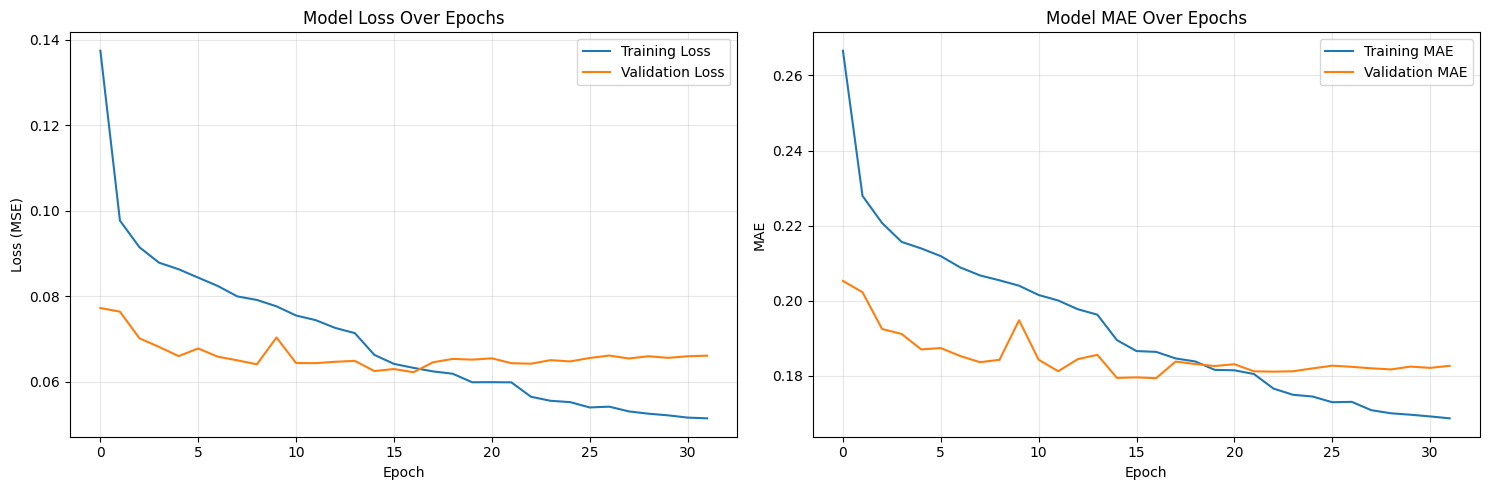

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('Model MAE Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()


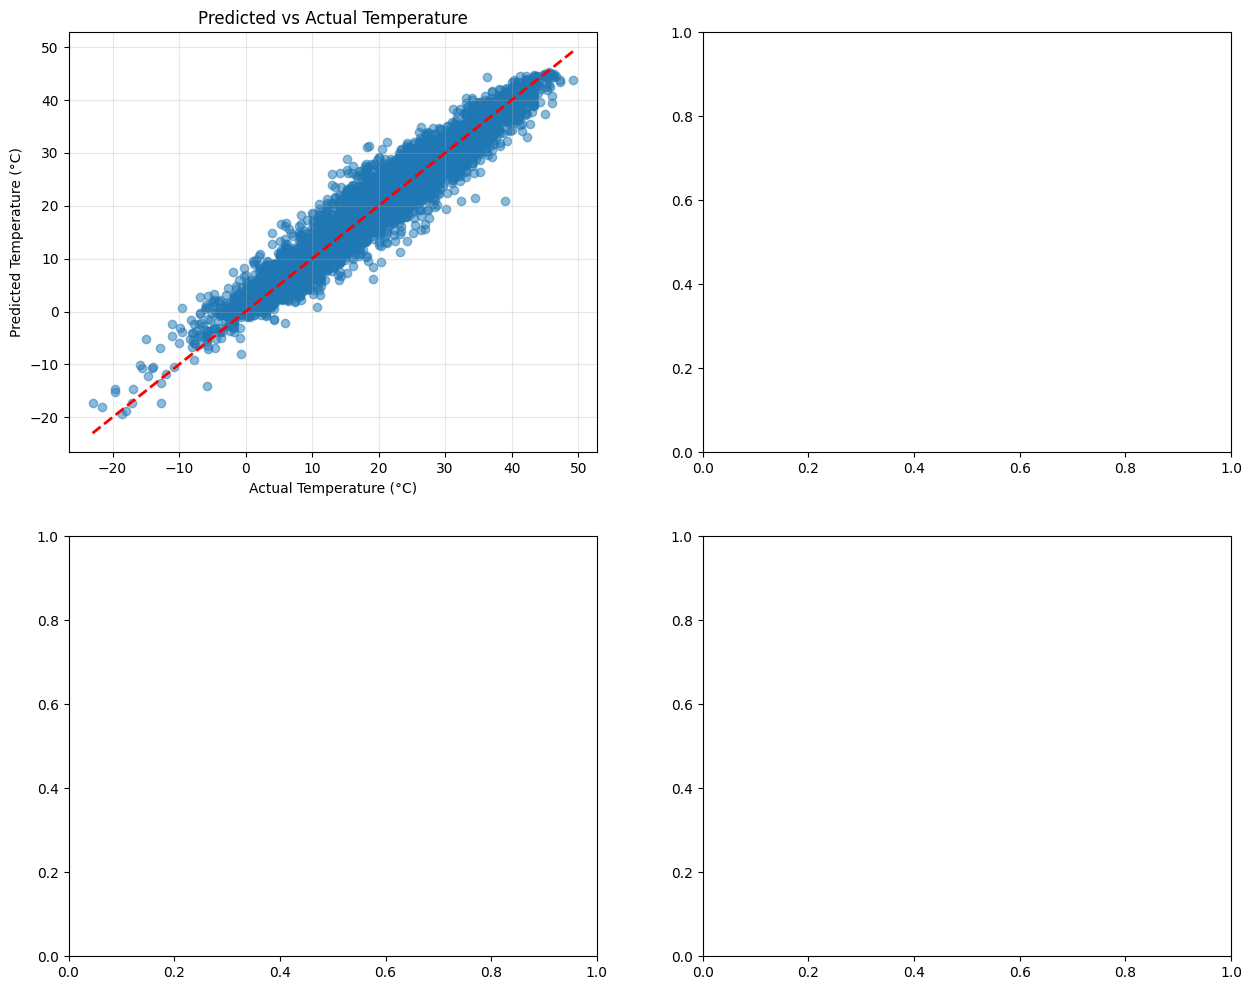

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot
axes[0, 0].scatter(y_test_original, y_pred_original, alpha=0.5)
axes[0, 0].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 
                'r--', lw=2)
axes[0, 0].set_xlabel('Actual Temperature (°C)')
axes[0, 0].set_ylabel('Predicted Temperature (°C)')
axes[0, 0].set_title('Predicted vs Actual Temperature')
axes[0, 0].grid(True, alpha=0.3)

In [30]:
residuals = y_test_original - y_pred_original
axes[0, 1].scatter(y_pred_original, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Temperature (°C)')
axes[0, 1].set_ylabel('Residuals (°C)')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

In [31]:
# Residual distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals (°C)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residual Distribution')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].grid(True, alpha=0.3)

In [32]:
# Time series sample (first 100 predictions)
sample_size = min(100, len(y_test_original))
axes[1, 1].plot(range(sample_size), y_test_original[:sample_size], 
                label='Actual', marker='o', markersize=3)
axes[1, 1].plot(range(sample_size), y_pred_original[:sample_size], 
                label='Predicted', marker='x', markersize=3)
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Temperature (°C)')
axes[1, 1].set_title('Sample Predictions (First 100)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

In [33]:
import pickle

In [34]:
# Save the model
model.save('global_weather_lstm_model.h5')
model.save('global_weather_lstm_model.keras')

# Save scalers
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

with open('target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

# Save location encoder
with open('location_encoder.pkl', 'wb') as f:
    pickle.dump(le_location, f)

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_cols_final, f)

print("Model and preprocessing objects saved!")
print("\nSaved files:")
print("- global_weather_lstm_model.h5")
print("- global_weather_lstm_model.keras")
print("- feature_scaler.pkl")
print("- target_scaler.pkl")
print("- location_encoder.pkl")
print("- feature_names.pkl")

Model and preprocessing objects saved!

Saved files:
- global_weather_lstm_model.h5
- global_weather_lstm_model.keras
- feature_scaler.pkl
- target_scaler.pkl
- location_encoder.pkl
- feature_names.pkl


In [35]:
def predict_temperature(model, last_7_days_data, feature_scaler, target_scaler, feature_cols):
    """
    Predict temperature for the next day
    
    Args:
        model: Trained LSTM model
        last_7_days_data: DataFrame with last 7 days of weather data
        feature_scaler: Fitted StandardScaler for features
        target_scaler: Fitted StandardScaler for target
        feature_cols: List of feature column names
    
    Returns:
        Predicted temperature in Celsius
    """
    # Scale the input data
    X_input = feature_scaler.transform(last_7_days_data[feature_cols])
    X_input = X_input.reshape(1, 7, len(feature_cols))
    
    # Make prediction
    y_pred_scaled = model.predict(X_input, verbose=0)
    
    # Inverse transform to original scale
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    
    return y_pred[0][0]

print("Prediction function defined!")
print("\nUsage example:")
print("predicted_temp = predict_temperature(model, last_7_days_df, feature_scaler, target_scaler, feature_cols_final)")

Prediction function defined!

Usage example:
predicted_temp = predict_temperature(model, last_7_days_df, feature_scaler, target_scaler, feature_cols_final)


In [37]:
print(f"\n Dataset:")
print(f"   - Total samples: {df.shape[0]:,}")
print(f"   - Number of locations: {len(locations)}")
print(f"   - Date range: {df['last_updated'].min()} to {df['last_updated'].max()}")
print(f"   - Features used: {len(feature_cols_final)}")
print(f"\n Sequences:")
print(f"   - Sequence length: {SEQUENCE_LENGTH} days")
print(f"   - Total sequences: {X_sequences.shape[0]:,}")
print(f"   - Training samples: {X_train.shape[0]:,}")
print(f"   - Validation samples: {X_val.shape[0]:,}")
print(f"   - Test samples: {X_test.shape[0]:,}")
print(f"\n Model Architecture:")
print(f"   - Type: Stacked LSTM (3 layers)")
print(f"   - Parameters: {model.count_params():,}")
print(f"   - Optimizer: Adam")
print(f"   - Loss: MSE")
print(f"\n Performance (Test Set):")
print(f"   - MAE: {mae_original:.2f}°C")
print(f"   - RMSE: {rmse_original:.2f}°C")
print(f"\n Saved Files:")
print(f"   - Model: global_weather_lstm_model.keras")
print(f"   - Scalers and encoders: *.pkl files")
print(f"   - Visualizations: *.png files")
print("\n Model ready for temperature prediction!")


 Dataset:
   - Total samples: 98,571
   - Number of locations: 221
   - Date range: 2024-05-16 01:45:00 to 2025-10-05 19:30:00
   - Features used: 58

 Sequences:
   - Sequence length: 7 days
   - Total sequences: 97,024
   - Training samples: 67,916
   - Validation samples: 14,554
   - Test samples: 14,554

 Model Architecture:
   - Type: Stacked LSTM (3 layers)
   - Parameters: 158,113
   - Optimizer: Adam
   - Loss: MSE

 Performance (Test Set):
   - MAE: 1.59°C
   - RMSE: 2.22°C

 Saved Files:
   - Model: global_weather_lstm_model.keras
   - Scalers and encoders: *.pkl files
   - Visualizations: *.png files

 Model ready for temperature prediction!
